# Notebook for visualizing the results of a stylegan3 training


In [19]:
import os

dataset_name = f"eiras"

experiment_number = 0
seed = 43
gpus = 2
batch = 128
CESGA = False

dataset_file = dataset_name + "_train" + (f"_{seed}" if seed is not None else "")

results_dir = f"training-runs/{dataset_file.upper()}"
experiment_name = f"000{experiment_number:0>2}-stylegan3-t-{dataset_file}-gpus{gpus}-batch{batch}-gamma0.125"

stats_filename = "stats.jsonl"
training_options_file_name = "training_options.json"
data_directory = "/mnt/netapp2/Store_uni/home/usc/ei/agl/data" if CESGA else "data"

dataset_summary_file_path = (
    f"{data_directory}/{dataset_name}/patches/processing_summary"
    + (f"_{seed}" if seed is not None and seed != 0 else "")
    + ".json"
)

stats_file_path = os.path.join(results_dir, experiment_name, stats_filename)
if not os.path.isfile(stats_file_path):
    print(f"Error: The file {stats_file_path} does not exist.")

import json

with open(dataset_summary_file_path, "r") as f:
    summary = json.load(f)

label_map = summary.get("label_map", {})
print("Label Map:", label_map)

# Labels for the classes
class_labels = [int(label) for label in label_map.keys()]
print("Class Labels:", class_labels)

Label Map: {'0': 1, '1': 2, '2': 3, '3': 4, '4': 5, '5': 6, '6': 7, '7': 8, '8': 9, '9': 10}
Class Labels: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


In [20]:
from visualization_utils import (
    read_jsonl,
    extract_metrics,
    extract_classification_metrics,
    summarize_training_stats,
    summarize_training_options,
    extract_confusion_matrix,
    plot_confusion_matrix,
    plot_metric,
    print_accuracies_per_class,
    compute_overall_accuracy,
    plot_accuracies,
    extract_best_tick,
    compute_adversarial_starting_tick,
    class_colors,
)

## Training summary


In [21]:
summarize_training_options(os.path.join(results_dir, experiment_name, training_options_file_name))

📋 Training Configuration Summary
────────────────────────────────────
⚖️ Class weight: 0.1
🎯 Classification start kimg: 0
🖥️ Number of GPUs: 2
📦 Batch size: 128
🎯 Uniform class labels: True
🧪 Discriminator on generated images: True
🖼️ Autoencoder kimg: 0
⏳ Autoencoder patience: 0
🔍 Autoencoder min delta: 0.0
🎛️ ADA target present ✅ → Value: 0.6


In [22]:
jsonl_data = read_jsonl(stats_file_path)
metrics = extract_metrics(jsonl_data, class_labels=class_labels)
summarize_training_stats(metrics, exclude_first_tick=True)

🕒 Total time: 12min 12s
📊 Total kimg: 40.576
🖼️ Total autoencoder kimg: 0.0
📈 Total ticks: 4
⏱️ Mean time per tick: 2min 8s (std: 0s)
⏳ Mean time per kimg: 12s (std: 0s)


In [23]:
# Path to training options file
training_options_file_path = os.path.join(results_dir, experiment_name, training_options_file_name)

# Get autoencoder_kimg progress values
autoencoder_kimg_progress_values = metrics.get("Progress/autoencoder_kimg")
# Check if during the training we saved the autoencoder_kimg progress values
# If not we used the value from training options
if all(v is None for v in autoencoder_kimg_progress_values):
    autoencoder_kimg_progress_values = None

adversarial_starting_tick = compute_adversarial_starting_tick(
    training_options_file_path,
    autoencoder_kimg_progress_values,
)
print(f"Adversarial Starting Tick: {adversarial_starting_tick}")

Adversarial Starting Tick: 0


## Best metrics


In [24]:
print("────────────────────────────────────")
print("Using average accuracy as performance key")
print("────────────────────────────────────")
best_tick_performance = extract_best_tick(
    jsonl_data, class_labels, performance_key="avg", verbose=True, only_tick_with_pkl=False, network_snapshot_ticks=None
)

────────────────────────────────────
Using average accuracy as performance key
────────────────────────────────────
📊 Best Tick Performance Summary
────────────────────────────────────
⏱️  Tick: 4
🖼️  kimg: 40.576
📈 Avg Accuracy (Train): 0.5994 ± 0.3044
📊 Avg Accuracy (Val):   0.6078 ± 0.3530
🏁 Overall Accuracy (Train): 0.8360
✅ Overall Accuracy (Val):   0.8398


## Loss plots


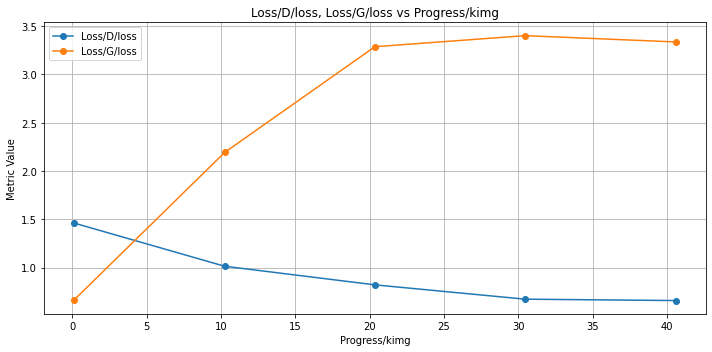

In [25]:
plot_metric(
    metrics, metrics=["Loss/D/loss", "Loss/G/loss"], x_axis="Progress/kimg", start_tick=adversarial_starting_tick
)

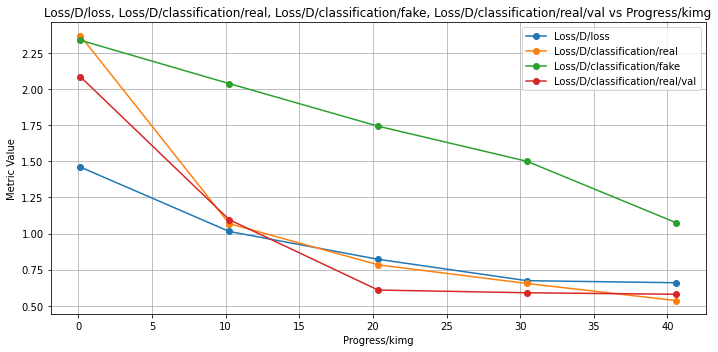

In [26]:
plot_metric(
    data=metrics,
    metrics=[
        "Loss/D/loss",
        "Loss/D/classification/real",
        "Loss/D/classification/fake",
        "Loss/D/classification/real/val",
    ],
    x_axis="Progress/kimg",
    start_tick=adversarial_starting_tick,
)

In [27]:
if "Loss/AE/loss" in metrics and any(metrics["Loss/AE/loss"]):
    plot_metric(
        metrics, metrics=["Loss/AE/loss"], x_axis="Progress/kimg", end_tick=adversarial_starting_tick - 1
    )  # do not include first adversarial tick
    plot_metric(
        metrics, metrics=["Loss/AE/val/loss"], x_axis="Progress/kimg", end_tick=adversarial_starting_tick - 1
    )  # do not include first adversarial tick

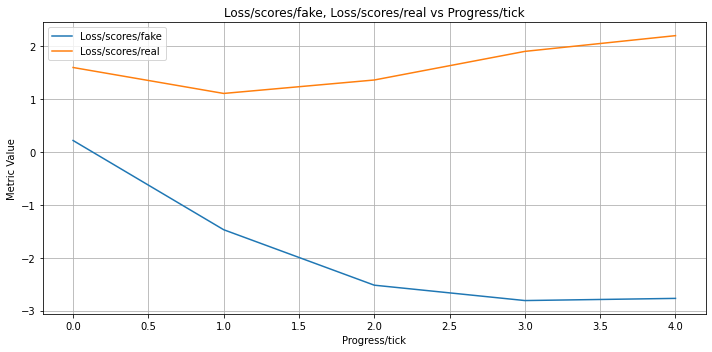

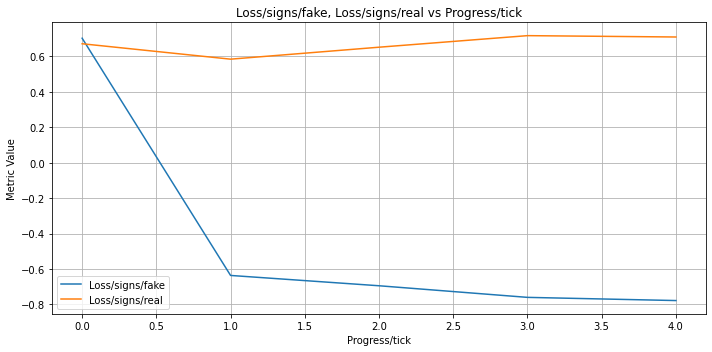

In [28]:
plot_metric(
    metrics,
    metrics=["Loss/scores/fake", "Loss/scores/real"],
    x_axis="Progress/tick",
    marker=None,
    start_tick=adversarial_starting_tick,
)
plot_metric(
    metrics,
    metrics=["Loss/signs/fake", "Loss/signs/real"],
    x_axis="Progress/tick",
    marker=None,
    start_tick=adversarial_starting_tick,
)

## Accuracy plots


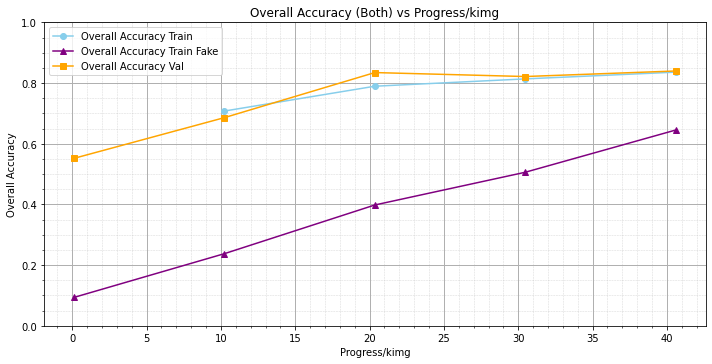

In [29]:
classification_metrics = extract_classification_metrics(jsonl_data, class_labels=class_labels)
metrics["overall_accuracy_train"], metrics["overall_accuracy_val"], metrics["overall_accuracy_train_fake"] = (
    compute_overall_accuracy(classification_metrics)
)
plot_accuracies(
    metrics,
    class_labels=class_labels,
    plot_std_in_avg_accuracy=False,
    plot_type="overall",
    dataset="both",
    include_fake=True,
    start_tick=adversarial_starting_tick,
)

Last 10 accuracies per class (val):
Class 0: ['0.000', '0.938', '0.885', '0.865', '0.875']
Class 1: ['0.000', '0.143', '0.476', '0.381', '0.762']
Class 2: ['0.056', '0.056', '0.944', '0.639', '0.778']
Class 3: ['0.000', '0.364', '0.727', '0.909', '0.727']
Class 4: ['0.200', '0.800', '0.200', '0.600', '0.200']
Class 5: ['0.000', '0.000', '0.000', '0.000', '1.000']
Class 6: ['0.000', '0.846', '0.544', '0.584', '0.765']
Class 7: ['0.979', '0.693', '0.979', '0.967', '0.912']
Class 8: ['0.000', '0.000', '0.059', '0.059', '0.059']
Class 9: ['0.000', '0.000', '0.000', '0.000', '0.000']
Average accuracies over the last 10 ticks: ['0.123', '0.384', '0.481', '0.500', '0.608']


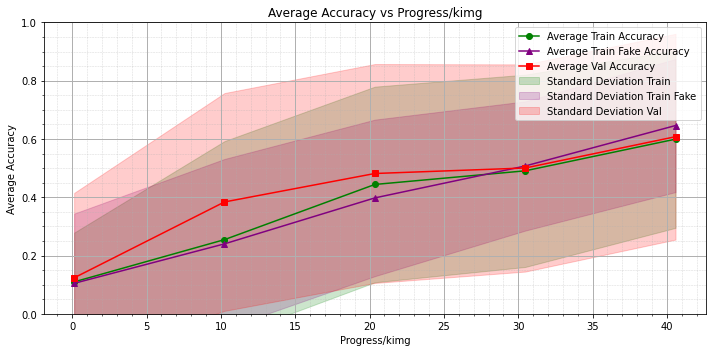

In [30]:
print_accuracies_per_class(metrics, class_labels, last_ticks=10, data_type="val")
plot_accuracies(
    metrics,
    class_labels=class_labels,
    plot_std_in_avg_accuracy=True,
    plot_type="average",
    dataset="both",
    include_fake=True,
    start_tick=adversarial_starting_tick,
)

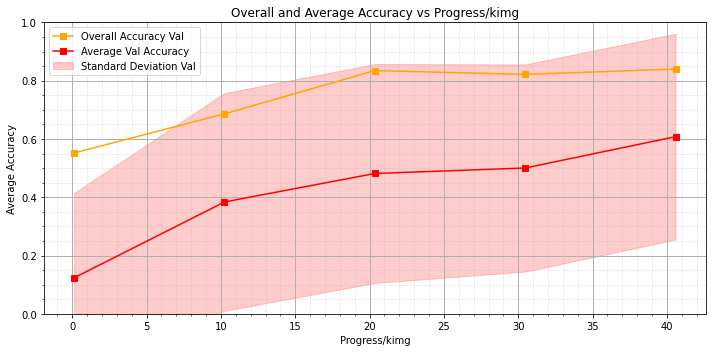

In [31]:
plot_accuracies(
    metrics,
    class_labels=class_labels,
    plot_std_in_avg_accuracy=True,
    plot_type="both",
    dataset="val",
    start_tick=adversarial_starting_tick,
)

### Class acuracies plots


In [32]:
class_names_map = [
    "Auga",
    "Terra",
    "Pedras",
    "Asfalto",
    "Formigón",
    "Tellados",
    "Prados",
    "Árbores Nativas",
    "Piñeiros",
    "Eucaliptos",
]

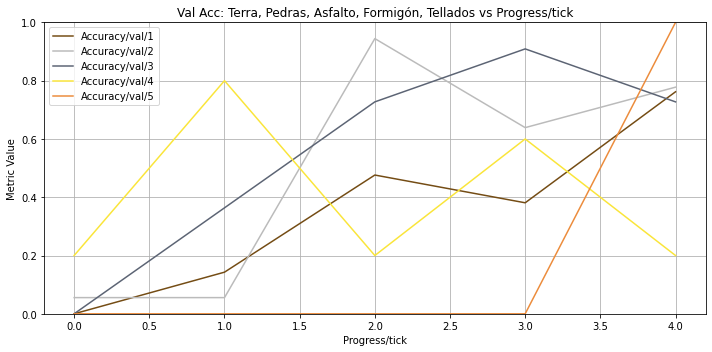

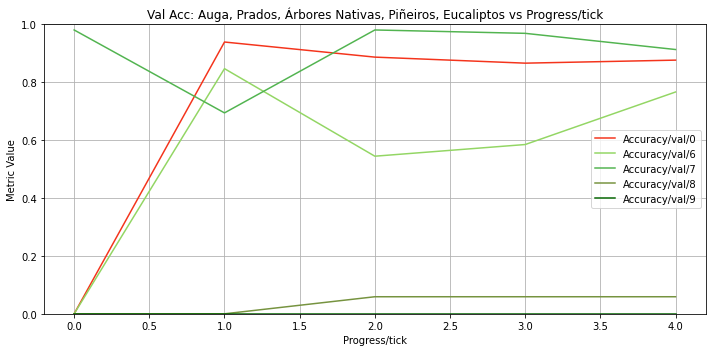

In [33]:
minority_class_labels = [1, 2, 3, 4, 5]
colors = [class_colors[c] for c in minority_class_labels]
plot_metric(
    metrics,
    metrics=[f"Accuracy/val/{c}" for c in minority_class_labels],
    x_axis="Progress/tick",
    marker=None,
    ylim=(0, 1),
    colors=colors,
    title="Val Acc: "
    + ", ".join(
        class_name for i, class_name in enumerate(class_names_map) if i in minority_class_labels and i in class_labels
    )
    + " vs Progress/tick",
    start_tick=adversarial_starting_tick,
)
mayority_class_labels = [0, 6, 7, 8, 9]
colors = [class_colors[c] for c in mayority_class_labels]
plot_metric(
    metrics,
    metrics=[f"Accuracy/val/{c}" for c in mayority_class_labels],
    x_axis="Progress/tick",
    marker=None,
    ylim=(0, 1),
    colors=colors,
    title="Val Acc: "
    + ", ".join(
        class_name for i, class_name in enumerate(class_names_map) if i in mayority_class_labels and i in class_labels
    )
    + " vs Progress/tick",
    start_tick=adversarial_starting_tick,
)

### Confusion matrix


Tick: 4/4
kimg used for training: 40.576/40.576


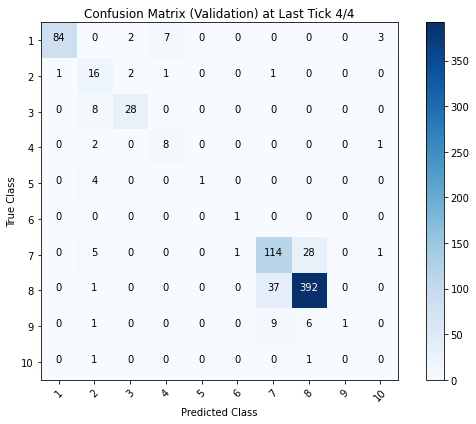

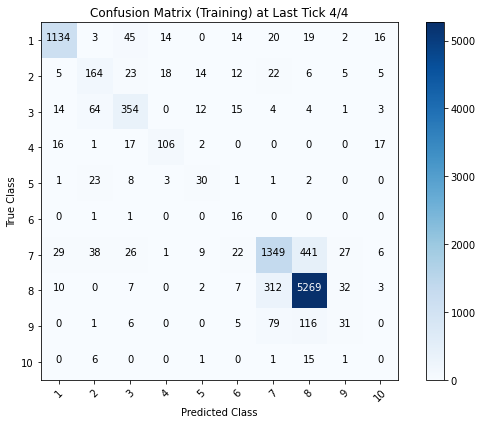

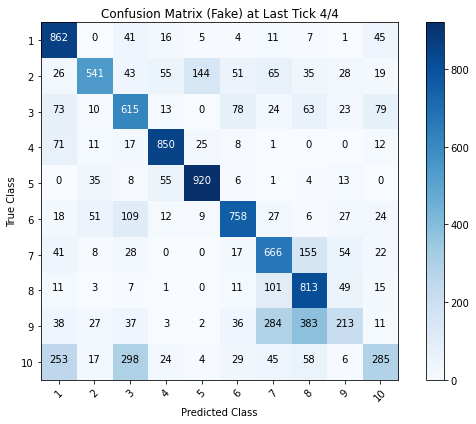

In [34]:
total_tick = int(metrics["Progress/tick"][-1])
total_kimg = float(metrics["Progress/kimg"][-1])

print(f"Tick: {total_tick}/{total_tick}")
print(f"kimg used for training: {total_kimg:.3f}/{total_kimg:.3f}")

# ------------- Validation ------------- #
confusion_matrix = extract_confusion_matrix(jsonl_data, class_labels=class_labels, data_type="val")
plot_confusion_matrix(
    confusion_matrix,
    class_labels=class_labels,
    title=f"Confusion Matrix (Validation) at Last Tick {total_tick}/{total_tick}",
)

# ------------- Training (real) ------------- #
try:
    confusion_matrix = extract_confusion_matrix(jsonl_data, class_labels=class_labels, data_type="real")
    plot_confusion_matrix(
        confusion_matrix,
        class_labels=class_labels,
        title=f"Confusion Matrix (Training) at Last Tick {total_tick}/{total_tick}",
    )

    # ------------- Training (fake) ------------- #
    confusion_matrix = extract_confusion_matrix(jsonl_data, class_labels=class_labels, data_type="fake")
    plot_confusion_matrix(
        confusion_matrix,
        class_labels=class_labels,
        title=f"Confusion Matrix (Fake) at Last Tick {total_tick}/{total_tick}",
    )
except KeyError:
    print("Classification training did not beginning yet, so no training confusion matrix to show.")

## Manifold metrics plots


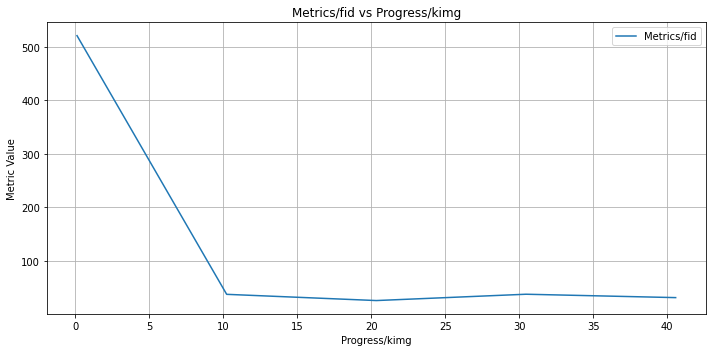

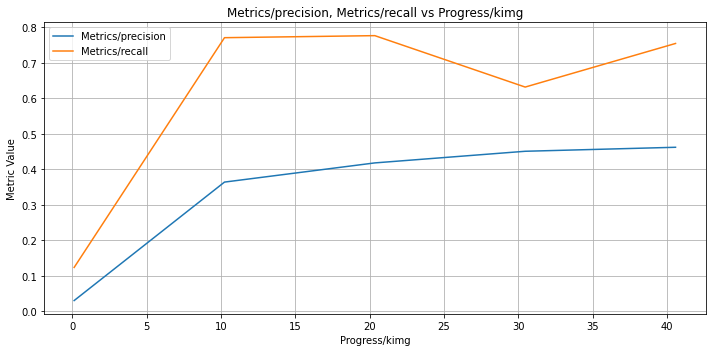

In [35]:
plot_metric(
    metrics,
    metrics=["Metrics/fid"],
    x_axis="Progress/kimg",
    marker=None,
    start_tick=adversarial_starting_tick,
)

plot_metric(
    metrics,
    metrics=["Metrics/precision", "Metrics/recall"],
    x_axis="Progress/kimg",
    marker=None,
    start_tick=adversarial_starting_tick,
)